# Drug Composition to Medical Indication Prediction
## Part 1: Data Preprocessing and EDA

This notebook covers:
1. Library installation
2. Data loading and exploration
3. Text preprocessing
4. Medical NER for indication extraction
5. Multi-label encoding preparation

## 1. Install Required Libraries

In [12]:
# Core libraries
!pip install pandas numpy matplotlib seaborn

# NLP libraries
!pip install transformers datasets torch
!pip install sentence-transformers
!pip install scikit-learn

# Medical NLP
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_md-0.5.1.tar.gz

# Visualization
!pip install wordcloud plotly

  Using cached spacy-3.8.11-cp310-cp310-macosx_11_0_arm64.whl.metadata (27 kB)
  Using cached thinc-8.3.10-cp310-cp310-macosx_11_0_arm64.whl.metadata (15 kB)
  Using cached blis-1.3.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (7.5 kB)
  Using cached pydantic-2.12.5-py3-none-any.whl.metadata (90 kB)
Using cached spacy-3.8.11-cp310-cp310-macosx_11_0_arm64.whl (6.2 MB)
Using cached thinc-8.3.10-cp310-cp310-macosx_11_0_arm64.whl (772 kB)
Using cached pydantic-2.12.5-py3-none-any.whl (463 kB)
Using cached blis-1.3.3-cp310-cp310-macosx_11_0_arm64.whl (1.2 MB)
  Attempting uninstall: blis
    Found existing installation: blis 0.7.11
    Uninstalling blis-0.7.11:
      Successfully uninstalled blis-0.7.11
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.24
    Uninstalling pydantic-1.10.24:
      Successfully uninstalled pydantic-1.10.24
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.12
    Uninstalling thinc-8.1.12:
      Successfully 

## 2. Import Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
from transformers import pipeline, AutoTokenizer
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## 3. Load Dataset

In [14]:
# Load MID2 dataset (preprocessed with multi-label format)
import ast

df = pd.read_csv('MID2_for_notebook.csv')

# Parse filtered_labels from string to list
df['filtered_labels'] = df['filtered_labels'].apply(ast.literal_eval)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

Dataset shape: (147831, 5)

Columns: ['NAME', 'CONTAINS', 'HOW_WORKS', 'filtered_labels', 'input_text']

First few rows:
                      NAME                  CONTAINS  \
0       Andol 0.5mg Tablet       Haloperidol (0.5mg)   
1  Avastin 100mg Injection       Bevacizumab (100mg)   
2    Actorise 40 Injection  Darbepoetin alfa (40mcg)   
3    Actorise 25 Injection  Darbepoetin alfa (25mcg)   
4    Actorise 60 Injection  Darbepoetin alfa (60mcg)   

                                                                                             HOW_WORKS  \
0  Andol 0.5mg Tablet is a typical antipsychotic. It works by blocking the action of dopamine, a ch...   
1  Avastin 100mg Injection is a anti-angiogenic medication. It works by blocking a protein called v...   
2  Actorise 40 Injection is an erythropoiesis-stimulating agent (ESA). It works by stimulating the ...   
3  Actorise 25 Injection is an erythropoiesis-stimulating agent (ESA). It works by stimulating the ...   
4  Actorise 

## 4. Exploratory Data Analysis

In [15]:
# Check dataset statistics
print("="*60)
print("Dataset Statistics")
print("="*60)

print(f"\nTotal drugs: {len(df)}")
print(f"Total unique labels: {len(set([label for labels in df['filtered_labels'] for label in labels]))}")
print(f"Average labels per drug: {df['filtered_labels'].apply(len).mean():.2f}")
print(f"Max labels per drug: {df['filtered_labels'].apply(len).max()}")
print(f"Min labels per drug: {df['filtered_labels'].apply(len).min()}")

# Check for missing values
print("\n" + "="*60)
print("Missing Values")
print("="*60)
print(df[['NAME', 'CONTAINS', 'HOW_WORKS', 'filtered_labels']].isnull().sum())

# Show sample data
print("\n" + "="*60)
print("Sample Drugs with Labels")
print("="*60)
for i in range(min(5, len(df))):
    print(f"\n{i+1}. {df.iloc[i]['NAME']}")
    print(f"   Composition: {df.iloc[i]['CONTAINS'][:80]}...")
    print(f"   Labels: {df.iloc[i]['filtered_labels']}")

Dataset Statistics

Total drugs: 147831
Total unique labels: 509
Average labels per drug: 1.57
Max labels per drug: 9
Min labels per drug: 1

Missing Values
NAME                 0
CONTAINS             0
HOW_WORKS          181
filtered_labels      0
dtype: int64

Sample Drugs with Labels

1. Andol 0.5mg Tablet
   Composition: Haloperidol (0.5mg)...
   Labels: ['Schizophrenia']

2. Avastin 100mg Injection
   Composition: Bevacizumab (100mg)...
   Labels: ['Cancer of colon and rectum', 'Non-small cell lung cancer', 'Kidney cancer', 'Brain tumor', 'Ovarian cancer', 'Cervical cancer']

3. Actorise 40 Injection
   Composition: Darbepoetin alfa (40mcg)...
   Labels: ['Anemia due to chronic kidney disease', 'Anemia due to cancer chemotherapy']

4. Actorise 25 Injection
   Composition: Darbepoetin alfa (25mcg)...
   Labels: ['Anemia due to chronic kidney disease', 'Anemia due to cancer chemotherapy']

5. Actorise 60 Injection
   Composition: Darbepoetin alfa (60mcg)...
   Labels: ['Anemia due t

## 5. Multi-Label Encoding

Create binary matrix for multi-label classification using MultiLabelBinarizer

In [16]:
# Create MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the labels
y = mlb.fit_transform(df['filtered_labels'])

print("="*60)
print("Multi-Label Encoding Statistics")
print("="*60)
print(f"\nNumber of samples: {len(df)}")
print(f"Number of unique labels: {len(mlb.classes_)}")
print(f"Label matrix shape: {y.shape}")
print(f"Average labels per sample: {y.sum(axis=1).mean():.2f}")
print(f"Max labels per sample: {y.sum(axis=1).max()}")
print(f"Min labels per sample: {y.sum(axis=1).min()}")

# Label distribution
label_counts = y.sum(axis=0)
print(f"\nLabel frequency:")
print(f"  Most common label appears in: {label_counts.max()} samples")
print(f"  Least common label appears in: {label_counts.min()} samples")
print(f"  Median frequency: {int(np.median(label_counts))} samples")

# Show top 20 most common labels
print("\n" + "="*60)
print("Top 20 Most Common Medical Conditions")
print("="*60)
label_freq = pd.DataFrame({
    'Condition': mlb.classes_,
    'Frequency': label_counts
}).sort_values('Frequency', ascending=False)

for i, row in label_freq.head(20).iterrows():
    print(f"{row['Frequency']:4d} samples - {row['Condition']}")

Multi-Label Encoding Statistics

Number of samples: 147831
Number of unique labels: 509
Label matrix shape: (147831, 509)
Average labels per sample: 1.57
Max labels per sample: 9
Min labels per sample: 1

Label frequency:
  Most common label appears in: 20439 samples
  Least common label appears in: 5 samples
  Median frequency: 62 samples

Top 20 Most Common Medical Conditions
20439 samples - Bacterial infections
13110 samples - Pain relief
10297 samples - Gastroesophageal reflux disease
8966 samples - Type
8966 samples - diabetes mellitus
7587 samples - Hypertension
4391 samples - Peptic ulcer disease/
3947 samples - Allergic conditions
3912 samples - Neuropathic pain
3617 samples - Sneezing and runny nose due to allergies/
3286 samples - Common cold
3246 samples - Zollinger-Ellison syndrome/
3183 samples - Prevention of heart attack and stroke/
3054 samples - Depression
2891 samples - Prevention of Heart attack
2646 samples - Epilepsy/Seizures
2572 samples - Fever
2564 samples - Hea

## 6. Prepare Feature Text

Use the pre-computed input_text that combines drug composition and mechanism of action

In [17]:
# Use pre-computed input_text from the CSV
X_text = df['input_text'].values

print("="*60)
print("Feature Text Statistics")
print("="*60)
print(f"\nNumber of samples: {len(X_text)}")
print(f"Average text length: {np.mean([len(text) for text in X_text]):.0f} characters")
print(f"Max text length: {max([len(text) for text in X_text])} characters")
print(f"Min text length: {min([len(text) for text in X_text])} characters")

# Show sample
print("\n" + "="*60)
print("Sample Input Text")
print("="*60)
for i in range(3):
    print(f"\n{i+1}. Drug: {df.iloc[i]['NAME']}")
    print(f"   Text: {X_text[i][:200]}...")
    print(f"   Labels: {df.iloc[i]['filtered_labels']}")

Feature Text Statistics

Number of samples: 147831
Average text length: 356 characters
Max text length: 2976 characters
Min text length: 57 characters

Sample Input Text

1. Drug: Andol 0.5mg Tablet
   Text: Drug Composition: Haloperidol (0.5mg) Mechanism of Action: Andol 0.5mg Tablet is a typical antipsychotic. It works by blocking the action of dopamine, a chemical messenger in the brain that affects th...
   Labels: ['Schizophrenia']

2. Drug: Avastin 100mg Injection
   Text: Drug Composition: Bevacizumab (100mg) Mechanism of Action: Avastin 100mg Injection is a anti-angiogenic medication. It works by blocking a protein called vascular endothelial growth factor (VEGF). Thi...
   Labels: ['Cancer of colon and rectum', 'Non-small cell lung cancer', 'Kidney cancer', 'Brain tumor', 'Ovarian cancer', 'Cervical cancer']

3. Drug: Actorise 40 Injection
   Text: Drug Composition: Darbepoetin alfa (40mcg) Mechanism of Action: Actorise 40 Injection is an erythropoiesis-stimulating agent (ESA)

## 7. Create Train/Test Split

Split data into training and testing sets (80/20 split)

In [ ]:
# Split data into train and test sets
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=None
)

# Also split the dataframe for reference
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42
)

print("="*60)
print("Train/Test Split")
print("="*60)
print(f"\nTraining set:")
print(f"  X_train shape: {X_train_text.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Number of samples: {len(X_train_text)}")

print(f"\nTest set:")
print(f"  X_test shape: {X_test_text.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Number of samples: {len(X_test_text)}")

print(f"\nLabel statistics:")
print(f"  Train - Avg labels per sample: {y_train.sum(axis=1).mean():.2f}")
print(f"  Test  - Avg labels per sample: {y_test.sum(axis=1).mean():.2f}")

# Check label distribution in train vs test
train_label_dist = y_train.sum(axis=0)
test_label_dist = y_test.sum(axis=0)

print(f"\n  Train - Total label occurrences: {y_train.sum()}")
print(f"  Test  - Total label occurrences: {y_test.sum()}")

Train/Test Split

Training set:
  X_train shape: (118264,)
  y_train shape: (118264, 509)
  Number of samples: 118264

Test set:
  X_test shape: (29567,)
  y_test shape: (29567, 509)
  Number of samples: 29567

Label statistics:
  Train - Avg labels per sample: 1.57
  Test  - Avg labels per sample: 1.57

  Train - Total label occurrences: 186018
  Test  - Total label occurrences: 46438


## 8. Save Processed Data

Save train/test splits and MultiLabelBinarizer for use in model training

In [ ]:
import pickle
import os

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Save training data
np.save('data/X_train_text.npy', X_train_text)
np.save('data/y_train.npy', y_train)

# Save test data
np.save('data/X_test_text.npy', X_test_text)
np.save('data/y_test.npy', y_test)

# Save full data
np.save('data/X_full.npy', X_text)
np.save('data/y_full.npy', y)

# Save MultiLabelBinarizer
with open('data/mlb.pkl', 'wb') as f:
    pickle.dump(mlb, f)

# Save dataframes for reference
df_train.to_csv('data/train_drugs.csv', index=False)
df_test.to_csv('data/test_drugs.csv', index=False)
df.to_csv('data/full_dataset.csv', index=False)

print("="*60)
print("✅ Data Saved Successfully")
print("="*60)
print("\nSaved files:")
print("  1. data/X_train_text.npy - Training text features")
print("  2. data/y_train.npy - Training labels (binary matrix)")
print("  3. data/X_test_text.npy - Test text features")
print("  4. data/y_test.npy - Test labels (binary matrix)")
print("  5. data/X_full.npy - All text features")
print("  6. data/y_full.npy - All labels (binary matrix)")
print("  7. data/mlb.pkl - MultiLabelBinarizer (for encoding/decoding)")
print("  8. data/train_drugs.csv - Training drug details")
print("  9. data/test_drugs.csv - Test drug details")
print(" 10. data/full_dataset.csv - Full dataset with labels")

print("\n" + "="*60)
print("Data Format Summary")
print("="*60)
print(f"\nX (features): numpy arrays of text strings")
print(f"y (labels): binary matrices of shape (n_samples, n_labels)")
print(f"  - Each row represents one drug")
print(f"  - Each column represents one medical condition")
print(f"  - Value 1 means the drug treats that condition")
print(f"  - Value 0 means the drug does not treat that condition")

print(f"\nTo load the data:")
print("```python")
print("import numpy as np")
print("import pickle")
print("")
print("X_train = np.load('data/X_train_text.npy', allow_pickle=True)")
print("y_train = np.load('data/y_train.npy')")
print("X_test = np.load('data/X_test_text.npy', allow_pickle=True)")
print("y_test = np.load('data/y_test.npy')")
print("mlb = pickle.load(open('data/mlb.pkl', 'rb'))")
print("```")

✅ Data Saved Successfully

Saved files:
  1. data/X_train_text.npy - Training text features
  2. data/y_train.npy - Training labels (binary matrix)
  3. data/X_test_text.npy - Test text features
  4. data/y_test.npy - Test labels (binary matrix)
  5. data/X_full.npy - All text features
  6. data/y_full.npy - All labels (binary matrix)
  7. data/mlb.pkl - MultiLabelBinarizer (for encoding/decoding)
  8. data/train_drugs.csv - Training drug details
  9. data/test_drugs.csv - Test drug details
 10. data/full_dataset.csv - Full dataset with labels

Data Format Summary

X (features): numpy arrays of text strings
y (labels): binary matrices of shape (n_samples, n_labels)
  - Each row represents one drug
  - Each column represents one medical condition
  - Value 1 means the drug treats that condition
  - Value 0 means the drug does not treat that condition

To load the data:
```python
import numpy as np
import pickle

X_train = np.load('data/X_train_text.npy', allow_pickle=True)
y_train = np.

## 9. Visualize Label Distribution

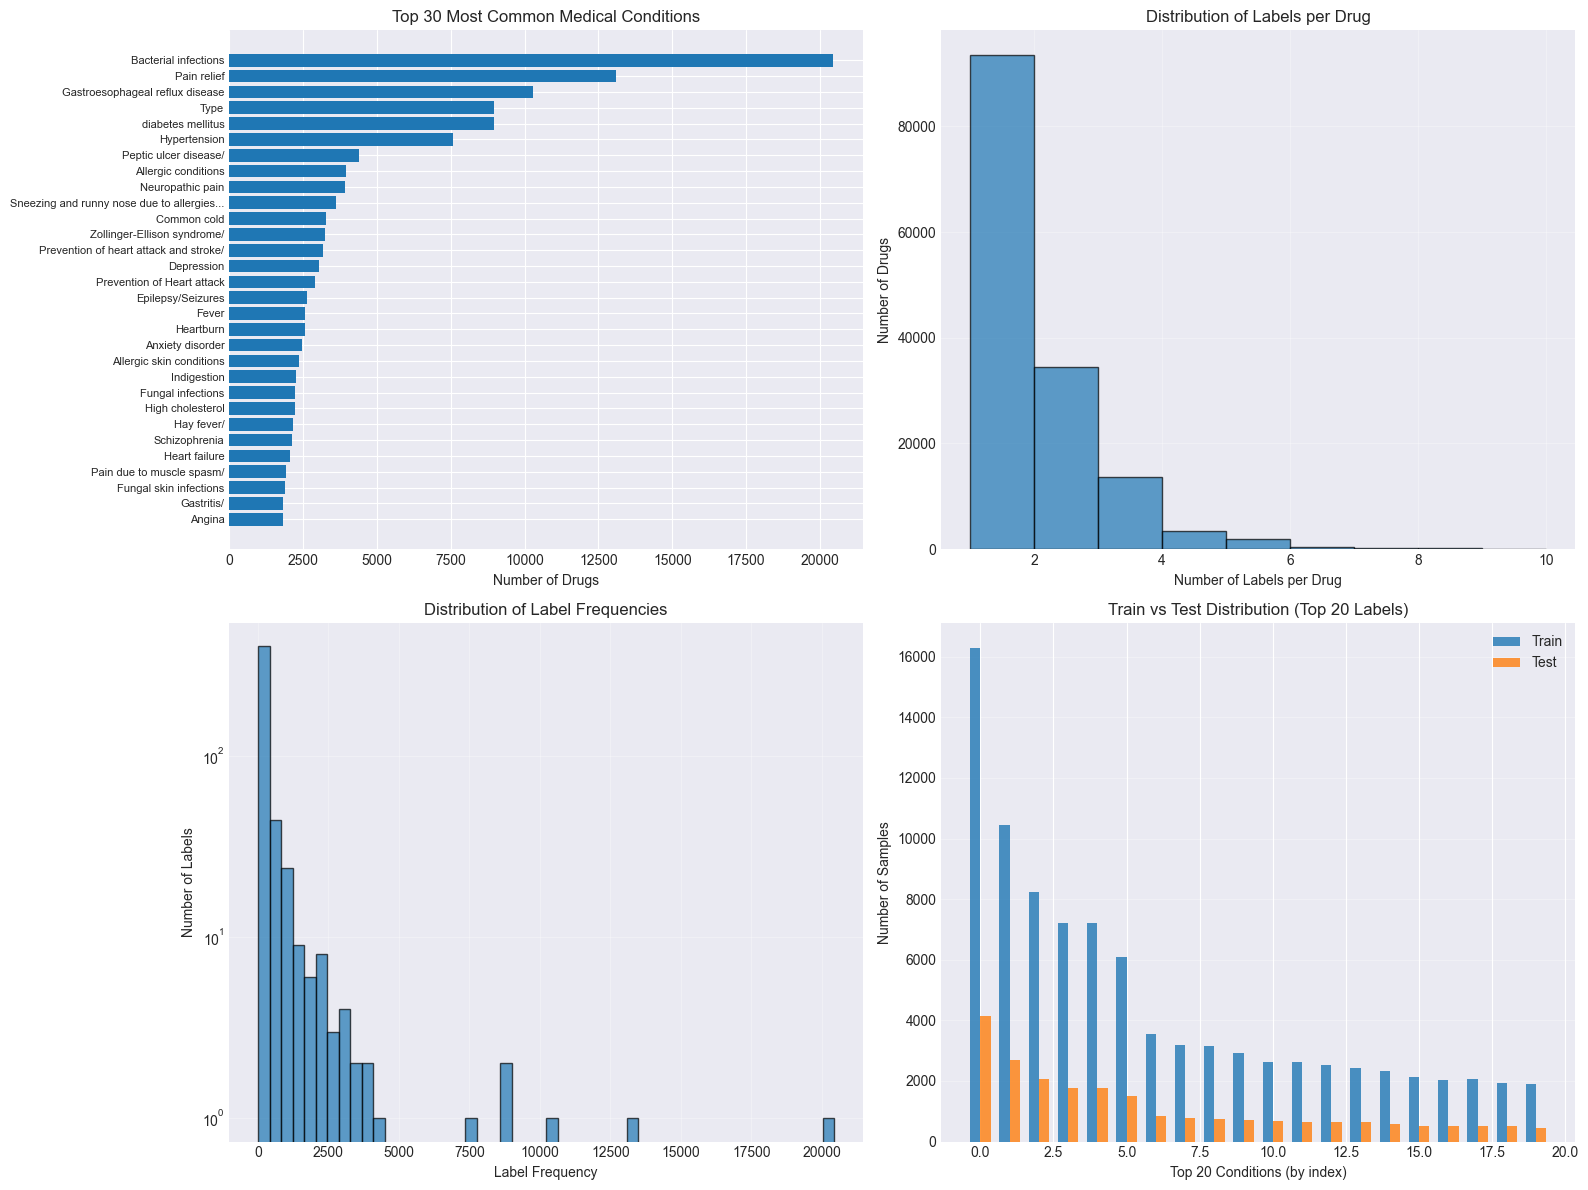

✅ Visualization saved as 'label_distribution_analysis.png'


In [20]:
# Visualize label distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 30 most common labels
label_freq = pd.DataFrame({
    'Condition': mlb.classes_,
    'Frequency': y.sum(axis=0)
}).sort_values('Frequency', ascending=False)

top_30 = label_freq.head(30)
axes[0, 0].barh(range(len(top_30)), top_30['Frequency'].values)
axes[0, 0].set_yticks(range(len(top_30)))
axes[0, 0].set_yticklabels([c[:40] + '...' if len(c) > 40 else c for c in top_30['Condition'].values], fontsize=8)
axes[0, 0].set_xlabel('Number of Drugs')
axes[0, 0].set_title('Top 30 Most Common Medical Conditions')
axes[0, 0].invert_yaxis()

# 2. Distribution of labels per drug
labels_per_drug = y.sum(axis=1)
axes[0, 1].hist(labels_per_drug, bins=range(1, labels_per_drug.max() + 2), edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Number of Labels per Drug')
axes[0, 1].set_ylabel('Number of Drugs')
axes[0, 1].set_title('Distribution of Labels per Drug')
axes[0, 1].grid(True, alpha=0.3)

# 3. Label frequency distribution (log scale)
axes[1, 0].hist(label_freq['Frequency'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Label Frequency')
axes[1, 0].set_ylabel('Number of Labels')
axes[1, 0].set_title('Distribution of Label Frequencies')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# 4. Train vs Test label distribution (top 20)
top_20_indices = label_freq.head(20).index
train_top_20 = y_train[:, top_20_indices].sum(axis=0)
test_top_20 = y_test[:, top_20_indices].sum(axis=0)

x_pos = np.arange(len(top_20_indices))
width = 0.35

axes[1, 1].bar(x_pos - width/2, train_top_20, width, label='Train', alpha=0.8)
axes[1, 1].bar(x_pos + width/2, test_top_20, width, label='Test', alpha=0.8)
axes[1, 1].set_xlabel('Top 20 Conditions (by index)')
axes[1, 1].set_ylabel('Number of Samples')
axes[1, 1].set_title('Train vs Test Distribution (Top 20 Labels)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('label_distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved as 'label_distribution_analysis.png'")

## 10. Summary & Next Steps

### ✅ Data Preprocessing Complete!

**What we've done:**
1. Loaded MID2 dataset with pre-extracted multi-label conditions
2. Created binary label matrix using MultiLabelBinarizer
3. Prepared text features (drug composition + mechanism of action)
4. Split data into train (80%) and test (20%) sets
5. Saved all processed data for model training

**Output Files:**
- `data/X_train_text.npy` - Training features (text)
- `data/y_train.npy` - Training labels (binary matrix)
- `data/X_test_text.npy` - Test features (text)
- `data/y_test.npy` - Test labels (binary matrix)
- `data/mlb.pkl` - MultiLabelBinarizer for label encoding/decoding
- `data/train_drugs.csv`, `data/test_drugs.csv` - Reference datasets

**Next Steps:**
1. **Feature Extraction**: Use biomedical NER pipeline (`d4data/biomedical-ner-all`) to extract entities from input text
2. **Model Training**: Train multi-label classifiers (e.g., Multi-output Classifier, Classifier Chains)
3. **Evaluation**: Use multi-label metrics (Hamming Loss, Jaccard Score, F1 Score)
4. **Fine-tuning**: Experiment with different models and hyperparameters

KeyError: 'description'

Cleaning text fields...
Text cleaning complete!

Example - Original vs Cleaned:
Original: Lepirudin is indicated for anticoagulation in adult patients with acute coronary syndromes (ACS) such as unstable angina and acute myocardial infarction without ST elevation. In patients with ACS, lep

Cleaned: Lepirudin is indicated for anticoagulation in adult patients with acute coronary syndromes (ACS) such as unstable angina and acute myocardial infarction without ST elevation. In patients with ACS, lep


Combined input features created!

Example combined text (first 500 chars):
Description: Lepirudin is a recombinant hirudin formed by 65 amino acids that acts as a highly specific and direct thrombin inhibitor. Natural hirudin is an endogenous anticoagulant found in _Hirudo medicinalis_ leeches. Lepirudin is produced in yeast cells and is identical to natural hirudin except for the absence of sulfate on the tyrosine residue at position 63 and the substitution of leucine for isoleucine at position 1 (N-terminal end). Lepirudin is used as an anticoagulant in patients with


Loading Medical NER model...


model.safetensors:   0%|          | 0.00/266M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use mps:0


NER model loaded!


Sample text: Lepirudin is indicated for anticoagulation in adult patients with acute coronary syndromes (ACS) such as unstable angina and acute myocardial infarction without ST elevation. In patients with ACS, lep...

Extracted conditions: ['##embolic disease', '##top', '##rombo', 'coronary syndromes', 'acute', '##ocardial infarction']


Extracting medical conditions from all indications...
This may take 10-20 minutes depending on your machine.



  0%|          | 0/17430 [00:00<?, ?it/s]


Condition extraction complete!


Total conditions extracted: 5339
Unique conditions: 2274

Top 20 most common conditions:
infections                              :  161
infection                               :   58
diabetes mellitus                       :   49
leukemia                                :   49
cancer                                  :   40
schizophrenia                           :   36
##oma                                   :   34
tumors                                  :   30
pneumonia                               :   29
bacterial                               :   28
heart failure                           :   27
inflammatory disorders                  :   27
lung cancer                             :   26
hyper                                   :   23
multiple                                :   23
##yp                                    :   22
##te                                    :   20
asthma                                  :   20
chronic obstructive pulmonary disease   :   20
##ym              

Conditions with at least 5 occurrences: 231

Dataset size after filtering: 1630 drugs
Average conditions per drug: 1.54


Multi-label shape: (1630, 231)
Number of classes: 231

Class distribution (top 20):
infections                              :  161
infection                               :   58
diabetes mellitus                       :   49
leukemia                                :   49
cancer                                  :   40
schizophrenia                           :   36
##oma                                   :   34
tumors                                  :   30
pneumonia                               :   29
bacterial                               :   28
heart failure                           :   27
inflammatory disorders                  :   27
lung cancer                             :   26
hyper                                   :   23
multiple                                :   23
##yp                                    :   22
##te                                    :   20
asthma                                  :   20
chronic obstructive pulmonary disease   :   20
##ym                   

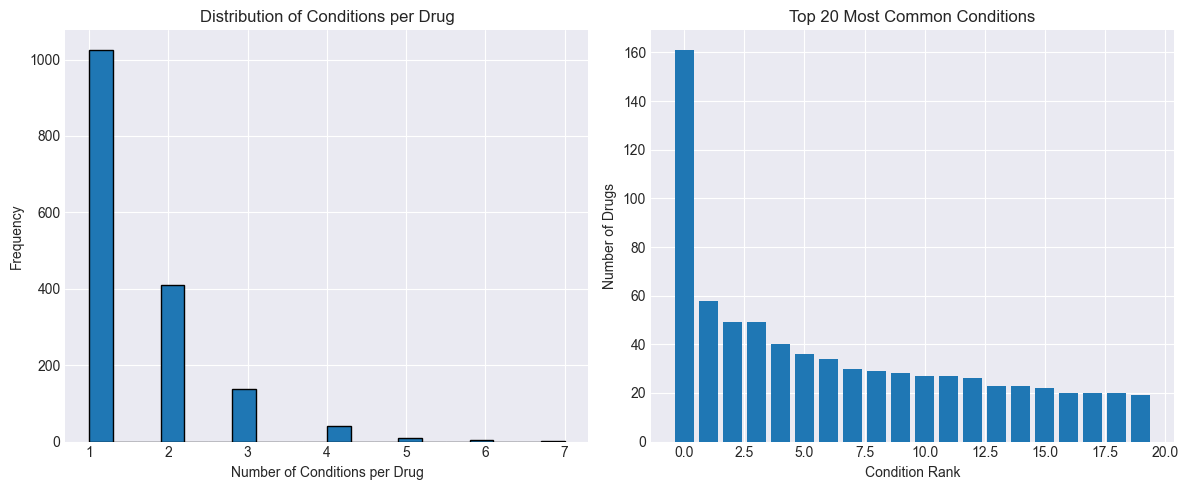

Training set: 1141 samples
Validation set: 244 samples
Test set: 245 samples

Number of labels: 231


Preprocessed data saved successfully!

Saved files:
- X_train.npy, X_val.npy, X_test.npy
- y_train.npy, y_val.npy, y_test.npy
- mlb.pkl (MultiLabelBinarizer)
- drugbank_preprocessed.csv
